### Project Goal & Overview

The goal of this project is to use data provided from the National Football League combined with other data sources to better analyze the performance of kickers and punters. The datasets provided from the NFL is located here https://www.kaggle.com/c/nfl-big-data-bowl-2022/data. I combined weather data providing insights regarding the field conditions for every NFL game https://github.com/ThompsonJamesBliss/WeatherData. This data was pulled from MeteoStat and Weather Underground. Lastly, I pulled data from nflfastR (https://www.nflfastr.com) to get another play-by-play information and metrics such as expected points added (EPA). The "full.csv" file provided contains all data after merging, cleaning, and feature engineering. 

Overall, the data was fairly clean except for some inconsistencies within certain features such as acceleration (denoted as "a") and missing values found in some features. This was largely solved through imputation techniques, data exploration, and intuition.

In [2]:
#Loading and installing libraries
import numpy as np 
import pandas as pd
from joypy import joyplot
import matplotlib.pyplot as plt

In [3]:
pd.set_option('display.max_columns', 500)
df = pd.read_csv('full.csv', low_memory=False)
df

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_id,Temperature,Humidity,Precipitation,WindSpeed,season,kicker,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,Justin Tucker,9.0,K,home,1,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,18.062652,46244.0,211.51,57.95,22.40,3.566090,44999.0,117.55,32.32,83.07,0.298952,138.239249,21.155998,2.414792,27.77672,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,Justin Tucker,9.0,K,home,2,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,17.626154,46244.0,210.30,57.95,22.39,3.527450,44999.0,117.55,32.32,82.49,0.291720,138.239249,21.155998,2.414792,27.77672,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,Justin Tucker,9.0,K,home,3,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,17.168055,46244.0,208.41,57.94,22.38,3.544968,44999.0,117.55,32.32,80.26,0.284084,138.239249,21.155998,2.414792,27.77672,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,Justin Tucker,9.0,K,home,4,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,16.705176,46244.0,210.60,57.93,22.36,3.618757,44999.0,117.55,32.32,83.25,0.276364,138.239249,21.155998,2.414792,27.77672,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,Justin Tucker,9.0,K,home,5,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,16.218733,46244.0,213.20,57.92,22.34,3.740976,44999.0,117.55,32.32,88.45,0.268258,138.239249,21.155998,2.414792,27.77672,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36267292,2020-09-15T05:22:39.200,117.23,32.02,1.13,0.85,0.12,NaN,NaN,None,NaN,football,NaN,NaN,football,81,2020091401,4280,right,S.Gostkowski kicks 65 yards from TEN 35 to end...,4,0,0,TEN,Kickoff,Touchback,30932.0,NaN,NaN,TEN,35,00:17:00,NaN,NaN,NaN,14,16,NaN,74.0,NaN,40,45,2020091401,71.06,27.0,0.0,5.59,2020,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36267293,2020-09-15T05:22:39.300,117.31,32.10,1.17,0.86,0.12,NaN,NaN,None,NaN,footba

# Final FG Model 

We are going to use XGBoost to predict the probability that a kicker will make a field goal. We will filter the data to only use the kicker data along with the feature engineering used to provide information regarding the location of the offensive and defensive players.

In [4]:
kicker = df[df['kicker']==1]
kicker

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_id,Temperature,Humidity,Precipitation,WindSpeed,season,kicker,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,Justin Tucker,9.0,K,home,1,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,18.062652,46244.0,211.51,57.95,22.40,3.566090,44999.0,117.55,32.32,83.07,0.298952,138.239249,21.155998,2.414792,27.776720,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,Justin Tucker,9.0,K,home,2,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,17.626154,46244.0,210.30,57.95,22.39,3.527450,44999.0,117.55,32.32,82.49,0.291720,138.239249,21.155998,2.414792,27.776720,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,Justin Tucker,9.0,K,home,3,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,17.168055,46244.0,208.41,57.94,22.38,3.544968,44999.0,117.55,32.32,80.26,0.284084,138.239249,21.155998,2.414792,27.776720,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,Justin Tucker,9.0,K,home,4,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,16.705176,46244.0,210.60,57.93,22.36,3.618757,44999.0,117.55,32.32,83.25,0.276364,138.239249,21.155998,2.414792,27.776720,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,Justin Tucker,9.0,K,home,5,2018123000,36,right,J.Tucker kicks 60 yards from BAL 35 to CLE 5. ...,1,0,0,BAL,Kickoff,Return,39470.0,44837.0,NaN,BAL,35,15:00:00,NaN,NaN,NaN,0,0,NaN,60.0,29.0,31,45,2018123000,42.98,70.0,0.0,0.00,2018,1,16.218733,46244.0,213.20,57.92,22.34,3.740976,44999.0,117.55,32.32,88.45,0.268258,138.239249,21.155998,2.414792,27.776720,11.126591,12.260801,6.559639,692.062265,37.200297,0.243711,0.012922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36265422,2020-09-15T05:22:39.200,73.40,29.75,1.40,0.43,0.14,16.51,30.30,None,30932.0,Stephen Gostkowski,3.0,K,away,81,2020091401,4280,right,S.Gostkowski kicks 65 yards from TEN 35 to end...,4,0,0,TEN,Kickoff,Touchback,30932.0,NaN,NaN,TEN,35,00:17:00,NaN,NaN,NaN,14,16,NaN,74.0,NaN,40,45,2020091401,71.06,27.0,0.0,5.59,2020,1,7.882360,48447.0,324.77,77.80,23.21,7.744114,46846.0,117.55,32.32,294.47,0.193287,120.496287,0.604880,2.078807,17.314155,12.513711,5.055063,5.391687,6458.96

In [5]:
kicker['specialTeamsPlayType'].value_counts()

Punt           634324
Kickoff        608799
Extra Point    178704
Field Goal     147654
Name: specialTeamsPlayType, dtype: int64

In [6]:
fg = kicker[kicker['specialTeamsPlayType']=='Field Goal']
fg

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_id,Temperature,Humidity,Precipitation,WindSpeed,season,kicker,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
2523,2018-12-30T21:35:00.300,79.36,31.16,0.47,0.10,0.05,140.22,315.96,None,39470.0,Justin Tucker,9.0,K,home,1,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,11.426395,46672.0,223.15,90.61,33.16,4.190764,31018.0,117.55,32.32,92.81,0.423936,2.747307,0.664073,0.945500,16.259537,5.817173,0.952034,2.883531,5513.479385,155.938431,0.202580,0.023885
2524,2018-12-30T21:35:00.400,79.34,31.19,0.41,0.21,0.04,140.22,316.80,None,39470.0,Justin Tucker,9.0,K,home,2,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,11.440883,46672.0,220.70,90.61,33.16,4.226795,31018.0,117.55,32.32,96.10,0.424474,2.747307,0.664073,0.945500,16.259537,5.817173,0.952034,2.883531,5513.479385,155.938431,0.202580,0.023885
2525,2018-12-30T21:35:00.500,79.31,31.22,0.35,0.40,0.04,140.22,316.65,None,39470.0,Justin Tucker,9.0,K,home,3,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,11.465322,46672.0,218.27,90.61,33.16,4.268677,31018.0,117.55,32.32,98.38,0.425381,2.747307,0.664073,0.945500,16.259537,5.817173,0.952034,2.883531,5513.479385,155.938431,0.202580,0.023885
2526,2018-12-30T21:35:00.600,79.29,31.24,0.29,0.54,0.03,140.22,318.90,None,39470.0,Justin Tucker,9.0,K,home,4,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,11.481672,46672.0,213.80,90.61,33.16,4.296603,31018.0,117.55,32.32,105.10,0.425987,2.747307,0.664073,0.945500,16.259537,5.817173,0.952034,2.883531,5513.479385,155.938431,0.202580,0.023885
2527,2018-12-30T21:35:00.700,79.28,31.26,0.23,0.65,0.03,138.96,326.80,None,39470.0,Justin Tucker,9.0,K,home,5,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,11.488207,46672.0,213.05,90.61,33.16,4.318669,31018.0,117.55,32.32,113.75,0.426230,2.747307,0.664073,0.945500,16.259537,5.817173,0.952034,2.883531,5513.479385,155.938431,0.202580,0.023885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36264303,2020-09-15T05:21:17.300,97.47,30.35,1.62,0.23,0.16,25.19,79.76,None,30932.0,Stephen Gostkowski,3.0,K,away,43,2020091401,4261,right,"(:20) S.Gostkowski 25 yard field goal is GOOD,...",4,4,1,TEN,Field Goal,Kick Attempt Good,30932.0,NaN,NaN,DEN,7,00:20:00,NaN,NaN,NaN,14,13,NaN,25.0,NaN,0,103,2020091401,71.06,27.0,0.0,5.59,2020,1,0.818841,42935.0,153.99,96.66,30.23,2.366030,35472.0,117.55,32.32,74.23,0.039003,4.9652

In [7]:
fg['event'].value_counts()

None                        139669
ball_snap                     2608
field_goal_attempt            2604
field_goal                    2177
field_goal_missed              392
line_set                        50
field_goal_blocked              38
autoevent_kickoff               34
tackle                          18
fumble_defense_recovered        16
first_contact                   15
field_goal_play                  7
fumble_offense_recovered         5
touchdown                        4
out_of_bounds                    3
penalty_flag                     2
punt                             2
kick_recovered                   2
kick_received                    2
fumble                           1
extra_point_attempt              1
extra_point                      1
touchback                        1
punt_land                        1
punt_downed                      1
Name: event, dtype: int64

In [8]:
# Filter when the ball was snapped
fg_snap = fg[fg['event']=='ball_snap']
fg_snap

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_id,Temperature,Humidity,Precipitation,WindSpeed,season,kicker,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
2533,2018-12-30T21:35:01.300,79.40,31.200000,0.29,0.17,0.04,130.24,118.34,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,11.233472,43491.0,270.09,90.62,31.750000,4.200202,31018.0,117.55,32.32,151.75,0.417043,NaN,NaN,NaN,NaN,11.233472,NaN,4.200202,NaN,151.75,0.417043,NaN
19883,2018-12-30T22:24:03.100,81.81,25.973333,0.18,0.19,0.04,310.20,314.85,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,1538,left,(6:15) (Field Goal formation) J.Tucker 35 yard...,2,4,10,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,16,06:15:00,NaN,NaN,NaN,17,7,NaN,35.0,NaN,0,26,2018123000,42.98,70.0,0.0,0.00,2018,1,11.471412,44813.0,82.30,93.28,26.153333,4.131053,31018.0,117.55,32.32,232.55,0.458102,NaN,NaN,NaN,NaN,11.471412,NaN,4.131053,NaN,232.55,0.458102,NaN
29077,2018-12-30T22:53:44.800,71.49,26.020000,0.00,0.00,0.00,132.80,122.39,ball_snap,46634.0,Greg Joseph,17.0,K,away,11,2018123000,2314,right,(:04) (Field Goal formation) G.Joseph 46 yard ...,2,1,5,CLE,Field Goal,Kick Attempt No Good,46634.0,NaN,NaN,BAL,28,00:04:00,NaN,NaN,NaN,20,7,NaN,46.0,NaN,-8,82,2018123000,42.98,70.0,0.0,0.00,2018,1,10.770241,43435.0,259.46,82.24,26.680000,3.729410,34723.0,117.55,32.32,137.07,0.301201,NaN,NaN,NaN,NaN,10.770241,NaN,3.729410,NaN,137.07,0.301201,NaN
37599,2018-12-30T23:30:40.900,73.54,32.850000,0.13,0.10,0.02,128.51,134.32,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,2860,right,(7:08) (Field Goal formation) J.Tucker 44 yard...,3,4,14,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,26,07:08:00,NaN,NaN,NaN,20,14,NaN,44.0,NaN,0,84,2018123000,42.98,70.0,0.0,0.00,2018,1,11.084728,43491.0,265.51,84.60,33.590000,4.337568,31018.0,117.55,32.32,131.19,0.336161,NaN,NaN,NaN,NaN,11.084728,NaN,4.337568,NaN,131.19,0.336161,NaN
47676,2018-12-30T23:50:23.200,82.85,32.390000,0.00,0.00,0.00,142.44,110.59,ball_snap,46634.0,Greg Joseph,17.0,K,away,11,2018123000,3378,right,(13:48) (Field Goal formation) G.Joseph 35 yar...,4,4,8,CLE,Field Goal,Kick Attempt Good,46634.0,NaN,NaN,BAL,17,13:48:00,NaN,NaN,NaN,23,14,NaN,35.0,NaN,0,93,2018123000,42.98,70.0,0.0,0.00,2018,1,10.642016,44999.0,235.63,93.38,33.930000,3.632754,34723.0,117.55,32.32,125.04,0.439325,NaN,NaN,NaN,NaN,10.642016,NaN,3.632754,NaN,125.04,0.439325,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36216315,2020-09-15T01:20:16.700,80.79,32.560000,0.01,0.02,0.02,133.24,161.42,ball_snap,41953.0,Chris Boswell,9.0,K,away,11,2020091400,2941,right,"(14:24) C.Boswell 36 yard field goal is GOOD, ...",4,4,10,PIT,Field Goal,Kick Attempt Good,41953.0,NaN,NaN,NYG,18,14:24:00,NaN,NaN,NaN,10,16,NaN,36.0,NaN,0,92,2020091400,69.08,45.0,0.0,11.18,2020,1,11.872464,46135.0,103.28,92.64,33.290000,4.352298,29926.0,117.55,32.32,58.14,0.476253,NaN,NaN,NaN,NaN,11.872464,NaN,4.352298,NaN,58.14,0.476253,NaN
36233129,2020-09-15T02:41:18.900,70.10,31.463333,0.07,0.06,0

In [9]:
# Filter when the field goal was attempted
fg_attempt = fg[fg['event']=='field_goal_attempt']
fg_attempt

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_id,Temperature,Humidity,Precipitation,WindSpeed,season,kicker,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
2548,2018-12-30T21:35:02.800,81.94,29.540000,2.71,2.84,0.28,133.48,107.47,field_goal_attempt,39470.0,Justin Tucker,9.0,K,home,26,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,4.383982,46672.0,279.64,84.86,32.810000,1.981338,31018.0,117.55,32.32,172.17,0.134093,NaN,NaN,NaN,NaN,4.383982,NaN,1.981338,NaN,172.17,0.134093,NaN
19898,2018-12-30T22:24:04.600,84.20,24.743333,2.95,1.77,0.30,298.90,285.10,field_goal_attempt,39470.0,Justin Tucker,9.0,K,home,26,2018123000,1538,left,(6:15) (Field Goal formation) J.Tucker 35 yard...,2,4,10,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,16,06:15:00,NaN,NaN,NaN,17,7,NaN,35.0,NaN,0,26,2018123000,42.98,70.0,0.0,0.00,2018,1,5.129464,46672.0,34.25,89.05,26.413333,1.931968,31018.0,117.55,32.32,250.85,0.176236,NaN,NaN,NaN,NaN,5.129464,NaN,1.931968,NaN,250.85,0.176236,NaN
29091,2018-12-30T22:53:46.200,73.21,25.080000,3.37,0.55,0.33,133.74,116.13,field_goal_attempt,46634.0,Greg Joseph,17.0,K,away,25,2018123000,2314,right,(:04) (Field Goal formation) G.Joseph 46 yard ...,2,1,5,CLE,Field Goal,Kick Attempt No Good,46634.0,NaN,NaN,BAL,28,00:04:00,NaN,NaN,NaN,20,7,NaN,46.0,NaN,-8,82,2018123000,42.98,70.0,0.0,0.00,2018,1,6.064297,43498.0,227.86,78.62,27.820000,2.039019,34723.0,117.55,32.32,111.73,0.154744,NaN,NaN,NaN,NaN,6.064297,NaN,2.039019,NaN,111.73,0.154744,NaN
37614,2018-12-30T23:30:42.400,75.60,31.220000,3.07,1.73,0.31,128.94,120.10,field_goal_attempt,39470.0,Justin Tucker,9.0,K,home,26,2018123000,2860,right,(7:08) (Field Goal formation) J.Tucker 44 yard...,3,4,14,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,26,07:08:00,NaN,NaN,NaN,20,14,NaN,44.0,NaN,0,84,2018123000,42.98,70.0,0.0,0.00,2018,1,5.531763,43637.0,332.07,79.62,27.420000,1.982044,31018.0,117.55,32.32,211.97,0.144639,NaN,NaN,NaN,NaN,5.531763,NaN,1.982044,NaN,211.97,0.144639,NaN
47690,2018-12-30T23:50:24.600,84.18,31.510000,3.40,1.68,0.32,144.40,121.52,field_goal_attempt,46634.0,Greg Joseph,17.0,K,away,25,2018123000,3378,right,(13:48) (Field Goal formation) G.Joseph 35 yar...,4,4,8,CLE,Field Goal,Kick Attempt Good,46634.0,NaN,NaN,BAL,17,13:48:00,NaN,NaN,NaN,23,14,NaN,35.0,NaN,0,93,2018123000,42.98,70.0,0.0,0.00,2018,1,7.101774,46187.0,267.56,90.54,34.670000,2.273785,34723.0,117.55,32.32,146.04,0.261942,NaN,NaN,NaN,NaN,7.101774,NaN,2.273785,NaN,146.04,0.261942,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36216330,2020-09-15T01:20:18.200,83.77,31.080000,2.76,2.86,0.28,113.92,106.03,field_goal_attempt,41953.0,Chris Boswell,9.0,K,away,26,2020091400,2941,right,"(14:24) C.Boswell 36 yard field goal is GOOD, ...",4,4,10,PIT,Field Goal,Kick Attempt Good,41953.0,NaN,NaN,NYG,18,14:24:00,NaN,NaN,NaN,10,16,NaN,36.0,NaN,0,92,2020091400,69.08,45.0,0.0,11.18,2020,1,4.843139,47963.0,243.27,87.93,33.560000,1.522104,29926.0,117.55,32.32,137.24,0.163366,NaN,NaN,NaN,NaN,4.843139,NaN,1.522104,NaN,137.24,0.163366,NaN
36233144,2020-09

In [10]:
fg = fg_snap.append(fg_attempt, ignore_index=True)
fg

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_id,Temperature,Humidity,Precipitation,WindSpeed,season,kicker,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio
0,2018-12-30T21:35:01.300,79.40,31.200000,0.29,0.17,0.04,130.24,118.34,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,11.233472,43491.0,270.09,90.62,31.750000,4.200202,31018.0,117.55,32.32,151.75,0.417043,NaN,NaN,NaN,NaN,11.233472,NaN,4.200202,NaN,151.75,0.417043,NaN
1,2018-12-30T22:24:03.100,81.81,25.973333,0.18,0.19,0.04,310.20,314.85,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,1538,left,(6:15) (Field Goal formation) J.Tucker 35 yard...,2,4,10,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,16,06:15:00,NaN,NaN,NaN,17,7,NaN,35.0,NaN,0,26,2018123000,42.98,70.0,0.0,0.00,2018,1,11.471412,44813.0,82.30,93.28,26.153333,4.131053,31018.0,117.55,32.32,232.55,0.458102,NaN,NaN,NaN,NaN,11.471412,NaN,4.131053,NaN,232.55,0.458102,NaN
2,2018-12-30T22:53:44.800,71.49,26.020000,0.00,0.00,0.00,132.80,122.39,ball_snap,46634.0,Greg Joseph,17.0,K,away,11,2018123000,2314,right,(:04) (Field Goal formation) G.Joseph 46 yard ...,2,1,5,CLE,Field Goal,Kick Attempt No Good,46634.0,NaN,NaN,BAL,28,00:04:00,NaN,NaN,NaN,20,7,NaN,46.0,NaN,-8,82,2018123000,42.98,70.0,0.0,0.00,2018,1,10.770241,43435.0,259.46,82.24,26.680000,3.729410,34723.0,117.55,32.32,137.07,0.301201,NaN,NaN,NaN,NaN,10.770241,NaN,3.729410,NaN,137.07,0.301201,NaN
3,2018-12-30T23:30:40.900,73.54,32.850000,0.13,0.10,0.02,128.51,134.32,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,2860,right,(7:08) (Field Goal formation) J.Tucker 44 yard...,3,4,14,BAL,Field Goal,Kick Attempt Good,39470.0,NaN,NaN,CLE,26,07:08:00,NaN,NaN,NaN,20,14,NaN,44.0,NaN,0,84,2018123000,42.98,70.0,0.0,0.00,2018,1,11.084728,43491.0,265.51,84.60,33.590000,4.337568,31018.0,117.55,32.32,131.19,0.336161,NaN,NaN,NaN,NaN,11.084728,NaN,4.337568,NaN,131.19,0.336161,NaN
4,2018-12-30T23:50:23.200,82.85,32.390000,0.00,0.00,0.00,142.44,110.59,ball_snap,46634.0,Greg Joseph,17.0,K,away,11,2018123000,3378,right,(13:48) (Field Goal formation) G.Joseph 35 yar...,4,4,8,CLE,Field Goal,Kick Attempt Good,46634.0,NaN,NaN,BAL,17,13:48:00,NaN,NaN,NaN,23,14,NaN,35.0,NaN,0,93,2018123000,42.98,70.0,0.0,0.00,2018,1,10.642016,44999.0,235.63,93.38,33.930000,3.632754,34723.0,117.55,32.32,125.04,0.439325,NaN,NaN,NaN,NaN,10.642016,NaN,3.632754,NaN,125.04,0.439325,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,2020-09-15T01:20:18.200,83.77,31.080000,2.76,2.86,0.28,113.92,106.03,field_goal_attempt,41953.0,Chris Boswell,9.0,K,away,26,2020091400,2941,right,"(14:24) C.Boswell 36 yard field goal is GOOD, ...",4,4,10,PIT,Field Goal,Kick Attempt Good,41953.0,NaN,NaN,NYG,18,14:24:00,NaN,NaN,NaN,10,16,NaN,36.0,NaN,0,92,2020091400,69.08,45.0,0.0,11.18,2020,1,4.843139,47963.0,243.27,87.93,33.560000,1.522104,29926.0,117.55,32.32,137.24,0.163366,NaN,NaN,NaN,NaN,4.843139,NaN,1.522104,NaN,137.24,0.163366,NaN
5208,2020-09-15T02:41:20.400,72.01,30.703333,3.56,1.45,0.34,322.35,289.56,

In [11]:
fg['event'].value_counts()

ball_snap             2608
field_goal_attempt    2604
Name: event, dtype: int64

Now, we will calculate the distance of the field goal attempt which has a big impact in the difficulty of the kick.

In [12]:
# Field Goal Distance
fg['fg_dist'] = ((fg['x'] - 120)**2 + (fg['y'] - 26.33)**2)**0.5

In [13]:
fg = pd.get_dummies(fg, columns=['specialTeamsResult'])
fg

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,kickerId,returnerId,kickBlockerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_id,Temperature,Humidity,Precipitation,WindSpeed,season,kicker,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,fg_dist,specialTeamsResult_Blocked Kick Attempt,specialTeamsResult_Downed,specialTeamsResult_Kick Attempt Good,specialTeamsResult_Kick Attempt No Good,specialTeamsResult_Out of Bounds
0,2018-12-30T21:35:01.300,79.40,31.200000,0.29,0.17,0.04,130.24,118.34,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,373,right,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",1,4,8,BAL,Field Goal,39470.0,NaN,NaN,CLE,20,09:31:00,NaN,NaN,NaN,0,0,NaN,38.0,NaN,0,90,2018123000,42.98,70.0,0.0,0.00,2018,1,11.233472,43491.0,270.09,90.62,31.750000,4.200202,31018.0,117.55,32.32,151.75,0.417043,NaN,NaN,NaN,NaN,11.233472,NaN,4.200202,NaN,151.75,0.417043,NaN,40.891037,0,0,1,0,0
1,2018-12-30T22:24:03.100,81.81,25.973333,0.18,0.19,0.04,310.20,314.85,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,1538,left,(6:15) (Field Goal formation) J.Tucker 35 yard...,2,4,10,BAL,Field Goal,39470.0,NaN,NaN,CLE,16,06:15:00,NaN,NaN,NaN,17,7,NaN,35.0,NaN,0,26,2018123000,42.98,70.0,0.0,0.00,2018,1,11.471412,44813.0,82.30,93.28,26.153333,4.131053,31018.0,117.55,32.32,232.55,0.458102,NaN,NaN,NaN,NaN,11.471412,NaN,4.131053,NaN,232.55,0.458102,NaN,38.191665,0,0,1,0,0
2,2018-12-30T22:53:44.800,71.49,26.020000,0.00,0.00,0.00,132.80,122.39,ball_snap,46634.0,Greg Joseph,17.0,K,away,11,2018123000,2314,right,(:04) (Field Goal formation) G.Joseph 46 yard ...,2,1,5,CLE,Field Goal,46634.0,NaN,NaN,BAL,28,00:04:00,NaN,NaN,NaN,20,7,NaN,46.0,NaN,-8,82,2018123000,42.98,70.0,0.0,0.00,2018,1,10.770241,43435.0,259.46,82.24,26.680000,3.729410,34723.0,117.55,32.32,137.07,0.301201,NaN,NaN,NaN,NaN,10.770241,NaN,3.729410,NaN,137.07,0.301201,NaN,48.510991,0,0,0,1,0
3,2018-12-30T23:30:40.900,73.54,32.850000,0.13,0.10,0.02,128.51,134.32,ball_snap,39470.0,Justin Tucker,9.0,K,home,11,2018123000,2860,right,(7:08) (Field Goal formation) J.Tucker 44 yard...,3,4,14,BAL,Field Goal,39470.0,NaN,NaN,CLE,26,07:08:00,NaN,NaN,NaN,20,14,NaN,44.0,NaN,0,84,2018123000,42.98,70.0,0.0,0.00,2018,1,11.084728,43491.0,265.51,84.60,33.590000,4.337568,31018.0,117.55,32.32,131.19,0.336161,NaN,NaN,NaN,NaN,11.084728,NaN,4.337568,NaN,131.19,0.336161,NaN,46.915264,0,0,1,0,0
4,2018-12-30T23:50:23.200,82.85,32.390000,0.00,0.00,0.00,142.44,110.59,ball_snap,46634.0,Greg Joseph,17.0,K,away,11,2018123000,3378,right,(13:48) (Field Goal formation) G.Joseph 35 yar...,4,4,8,CLE,Field Goal,46634.0,NaN,NaN,BAL,17,13:48:00,NaN,NaN,NaN,23,14,NaN,35.0,NaN,0,93,2018123000,42.98,70.0,0.0,0.00,2018,1,10.642016,44999.0,235.63,93.38,33.930000,3.632754,34723.0,117.55,32.32,125.04,0.439325,NaN,NaN,NaN,NaN,10.642016,NaN,3.632754,NaN,125.04,0.439325,NaN,37.641016,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,2020-09-15T01:20:18.200,83.77,31.080000,2.76,2.86,0.28,113.92,106.03,field_goal_attempt,41953.0,Chris Boswell,9.0,K,away,26,2020091400,2941,right,"(14:24) C.Boswell 36 yard field goal is GOOD, ...",4,4,10,PIT,Field Goal,41953.0,NaN,NaN,NYG,18,14:24:00,NaN,NaN,NaN,10,16,NaN,36.0,NaN,0,92,2020091400,69.08,45.0,0.0,11.18,2020,1,4.843139,47963.0,243.27,87.93,33.560000,1.522104

Field goal distance has a great impact on the outcome of the play. The farther the attempt, the less likely it is going to be made. 

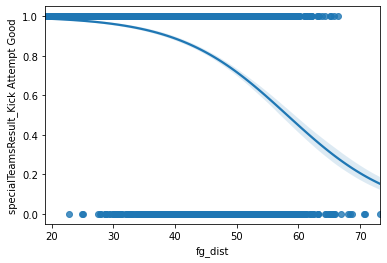

In [31]:
sns.regplot(x="fg_dist", y="specialTeamsResult_Kick Attempt Good", data=fg,
            logistic=True, ci=95);

In [45]:
# Visualize summary statistics for each variable
fg.describe()

,x,y,s,a,dis,o,dir,nflId,jerseyNumber,frameId,gameId,playId,quarter,down,yardsToGo,kickerId,kickBlockerId,yardlineNumber,penaltyYards,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber,game_id,Temperature,Humidity,Precipitation,WindSpeed,season,kicker,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,fg_dist,specialTeamsResult_Blocked Kick Attempt,specialTeamsResult_Downed,specialTeamsResult_Kick Attempt Good,specialTeamsResult_Kick Attempt No Good,specialTeamsResult_Out of Bounds
count,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5.212000e+03,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,72.000000,5212.000000,74.000000,5212.000000,5212.000000,5140.000000,0.0,5212.000000,5212.000000,5.212000e+03,5212.000000,5212.000000,4704.000000,5212.000000,5212.000000,5212.0,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5.212000e+03,5.212000e+03,5212.000000,5212.000000,0.0,0.0,0.0,0.0,5212.000000,0.0,5212.000000,0.0,5212.000000,5212.000000,0.0,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000,5212.000000
mean,80.084754,28.168287,1.460107,0.786213,0.150767,211.575086,196.865687,40335.357252,5.112241,18.313891,2.019094e+09,2231.891788,2.585380,3.819839,7.721412,40335.357252,43413.527778,20.192632,1.351351,11.495779,10.852456,38.124125,NaN,-1.348810,59.851113,2.019094e+09,60.507586,62.059094,0.004985,8.233613,2018.970645,1.0,8.563741,43252.653876,175.482448,88.179162,28.503222,2.609627,41576.055257,1.175500e+02,3.232000e+01,160.979144,0.341785,NaN,NaN,NaN,NaN,8.563741,NaN,2.609627,NaN,160.979144,0.341785,NaN,40.084594,0.013814,0.000192,0.839025,0.146777,0.000192
std,10.235836,3.061847,1.436983,0.882175,0.138915,92.663062,94.981323,6434.650341,2.817664,7.395228,8.408246e+05,1201.766041,1.093324,0.623814,4.735115,6434.650341,4049.564091,10.123196,5.318442,9.514373,9.541711,10.092323,NaN,4.025153,31.481845,8.408246e+05,16.781493,20.695459,0.025967,5.138384,0.811606,0.0,2.830603,4053.509838,97.806212,10.390546,3.206356,1.045019,5958.541148,3.126688e-13,4.164180e-12,66.734513,0.212642,NaN,NaN,NaN,NaN,2.830603,NaN,1.045019,NaN,66.734513,0.212642,NaN,10.196899,0.116731,0.013852,0.367543,0.353917,0.013852
min,46.790000,20.933333,0.000000,0.000000,0.000000,3.490000,0.000000,21213.000000,1.000000,3.000000,2.018091e+09,152.000000,1.000000,1.000000,1.000000,21213.000000,33131.000000,1.000000,-15.000000,0.000000,0.000000,19.000000,NaN,-72.000000,11.000000,2.018091e+09,10.940000,6.000000,0.000000,0.000000,2018.000000,1.0,1.949410,27132.000000,0.000000,54.620000,17.920000,0.927631,29043.000000,1.175500e+02,3.232000e+01,0.020000,0.051060,NaN,NaN,NaN,NaN,1.949410,NaN,0.927631,NaN,0.020000,0.051060,NaN,18.936570,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72.007500,24.998333,0.020000,0.020000,0.010000,123.030000,107.285000,38134.000000,3.000000,11.000000,2.018120e+09,1245.000000,2.000000,4.000000,4.000000,38134.000000,41152.250000,12.000000,0.000000,3.000000,3.000000,30.000000,NaN,0.000000,30.000000,2.018120e+09,47.300000,50.000000,0.000000,4.970000,2018.000000,1.0,5.878501,41316.000000,81.967500,80.215000,26.162500,1.584424,38138.000000,1.175500e+02,3.232000e+01,122.842500,0.183501,NaN,NaN,NaN,NaN,5.878501,NaN,1.584424,NaN,122.842500,0.183501,NaN,31.835119,0.000000,0.000000,1.000000,0.000000,0.000000
50%,79.885000,28.166667,0.960000,0.470000,0.105000,182.970000,184.820000,41431.500000,4.000000,11.000000,2.019110e+09,2166.000000,2.000000,4.000000,7.000000,41431.500000,43587.000000,20.500000,0.000000,10.000000,9.000000,38.000000,NaN,0.000000,58.000000,2.019110e+09,60.800000,63.000000,0.000000,8.080000,2019.000000,1.0,9.420186,43493.000000,177.320000,87.910000,27.613333,2.733413,42508.000000,1.175500e+02,3

In [14]:
fg.columns

Index(['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId',
       'displayName', 'jerseyNumber', 'position', 'team', 'frameId', 'gameId',
       'playId', 'playDirection', 'playDescription', 'quarter', 'down',
       'yardsToGo', 'possessionTeam', 'specialTeamsPlayType', 'kickerId',
       'returnerId', 'kickBlockerId', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers', 'penaltyYards',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'kickLength',
       'kickReturnYardage', 'playResult', 'absoluteYardlineNumber', 'game_id',
       'Temperature', 'Humidity', 'Precipitation', 'WindSpeed', 'season',
       'kicker', 'oppMinDist', 'closestOpp(nflId)', 'oppDir', 'oppX', 'oppY',
       'mateMinDist', 'closestMate(nflId)', 'mateX', 'mateY', 'diffDir',
       'oppMateDistRatio', 'varX', 'varY', 'varS', 'oppVar', 'oppMean',
       'mateVar', 'mateMean', 'oppDirVar', 'oppDirMean',
       'meanOppMateDistRatio', 'varOppMateDi

In [15]:
tests = fg[['s', 'a', 'dis', 'o', 'dir', 'event', 'frameId', 'gameId', 'playId', 'season', 'team', 'position',
       'displayName', 'quarter', 'oppMean', 'oppX', 'oppY', 'oppMinDist', 'oppMateDistRatio',
       'mateMinDist', 'mateX', 'mateY', 'diffDir', 'playDescription', 'kickLength',
       'yardsToGo', 'fg_dist', 'preSnapHomeScore', 'preSnapVisitorScore',
            'Temperature', 'Humidity', 'Precipitation', 'WindSpeed',
       'specialTeamsResult_Kick Attempt Good']]
tests

,s,a,dis,o,dir,event,frameId,gameId,playId,season,team,position,displayName,quarter,oppMean,oppX,oppY,oppMinDist,oppMateDistRatio,mateMinDist,mateX,mateY,diffDir,playDescription,kickLength,yardsToGo,fg_dist,preSnapHomeScore,preSnapVisitorScore,Temperature,Humidity,Precipitation,WindSpeed,specialTeamsResult_Kick Attempt Good
0,0.29,0.17,0.04,130.24,118.34,ball_snap,11,2018123000,373,2018,home,K,Justin Tucker,1,11.233472,90.62,31.750000,11.233472,0.417043,4.200202,117.55,32.32,151.75,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",38.0,8,40.891037,0,0,42.98,70.0,0.0,0.00,1
1,0.18,0.19,0.04,310.20,314.85,ball_snap,11,2018123000,1538,2018,home,K,Justin Tucker,2,11.471412,93.28,26.153333,11.471412,0.458102,4.131053,117.55,32.32,232.55,(6:15) (Field Goal formation) J.Tucker 35 yard...,35.0,10,38.191665,17,7,42.98,70.0,0.0,0.00,1
2,0.00,0.00,0.00,132.80,122.39,ball_snap,11,2018123000,2314,2018,away,K,Greg Joseph,2,10.770241,82.24,26.680000,10.770241,0.301201,3.729410,117.55,32.32,137.07,(:04) (Field Goal formation) G.Joseph 46 yard ...,46.0,5,48.510991,20,7,42.98,70.0,0.0,0.00,0
3,0.13,0.10,0.02,128.51,134.32,ball_snap,11,2018123000,2860,2018,home,K,Justin Tucker,3,11.084728,84.60,33.590000,11.084728,0.336161,4.337568,117.55,32.32,131.19,(7:08) (Field Goal formation) J.Tucker 44 yard...,44.0,14,46.915264,20,14,42.98,70.0,0.0,0.00,1
4,0.00,0.00,0.00,142.44,110.59,ball_snap,11,2018123000,3378,2018,away,K,Greg Joseph,4,10.642016,93.38,33.930000,10.642016,0.439325,3.632754,117.55,32.32,125.04,(13:48) (Field Goal formation) G.Joseph 35 yar...,35.0,8,37.641016,23,14,42.98,70.0,0.0,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,2.76,2.86,0.28,113.92,106.03,field_goal_attempt,26,2020091400,2941,2020,away,K,Chris Boswell,4,4.843139,87.93,33.560000,4.843139,0.163366,1.522104,117.55,32.32,137.24,"(14:24) C.Boswell 36 yard field goal is GOOD, ...",36.0,10,36.540052,10,16,69.08,45.0,0.0,11.18,1
5208,3.56,1.45,0.34,322.35,289.56,field_goal_attempt,26,2020091401,612,2020,away,K,Stephen Gostkowski,1,7.498513,79.22,28.643333,7.498513,0.194737,1.520691,117.55,32.32,211.12,(5:27) S.Gostkowski 47 yard field goal is No G...,47.0,7,48.188859,0,0,71.06,27.0,0.0,5.59,0
5209,3.67,0.72,0.36,122.38,108.95,field_goal_attempt,26,2020091401,2010,2020,away,K,Stephen Gostkowski,2,5.171305,79.92,33.110000,5.171305,0.137395,1.328834,117.55,32.32,118.43,(:12) S.Gostkowski 44 yard field goal is BLOCK...,NaN,12,44.993711,7,7,71.06,27.0,0.0,5.59,0
5210,3.45,1.16,0.34,321.04,289.00,field_goal_attempt,25,2020091401,2626,2020,away,K,Stephen Gostkowski,3,7.340191,82.84,24.873333,7.340191,0.206767,1.483543,117.55,32.32,164.64,(7:32) S.Gostkowski 42 yard field goal is No G...,42.0,10,42.995057,7,7,71.06,27.0,0.0,5.59,0


In [16]:
# Calculate difference in the score at the time of the field goal attempt. 
tests.loc[tests['team'] == 'away', 'ScoreDiff'] = tests['preSnapVisitorScore'] - tests['preSnapHomeScore']
tests.loc[tests['team'] == 'home', 'ScoreDiff'] = tests['preSnapHomeScore'] - tests['preSnapVisitorScore']
tests

/Users/benjenkins/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/Users/benjenkins/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,s,a,dis,o,dir,event,frameId,gameId,playId,season,team,position,displayName,quarter,oppMean,oppX,oppY,oppMinDist,oppMateDistRatio,mateMinDist,mateX,mateY,diffDir,playDescription,kickLength,yardsToGo,fg_dist,preSnapHomeScore,preSnapVisitorScore,Temperature,Humidity,Precipitation,WindSpeed,specialTeamsResult_Kick Attempt Good,ScoreDiff
0,0.29,0.17,0.04,130.24,118.34,ball_snap,11,2018123000,373,2018,home,K,Justin Tucker,1,11.233472,90.62,31.750000,11.233472,0.417043,4.200202,117.55,32.32,151.75,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",38.0,8,40.891037,0,0,42.98,70.0,0.0,0.00,1,0.0
1,0.18,0.19,0.04,310.20,314.85,ball_snap,11,2018123000,1538,2018,home,K,Justin Tucker,2,11.471412,93.28,26.153333,11.471412,0.458102,4.131053,117.55,32.32,232.55,(6:15) (Field Goal formation) J.Tucker 35 yard...,35.0,10,38.191665,17,7,42.98,70.0,0.0,0.00,1,10.0
2,0.00,0.00,0.00,132.80,122.39,ball_snap,11,2018123000,2314,2018,away,K,Greg Joseph,2,10.770241,82.24,26.680000,10.770241,0.301201,3.729410,117.55,32.32,137.07,(:04) (Field Goal formation) G.Joseph 46 yard ...,46.0,5,48.510991,20,7,42.98,70.0,0.0,0.00,0,-13.0
3,0.13,0.10,0.02,128.51,134.32,ball_snap,11,2018123000,2860,2018,home,K,Justin Tucker,3,11.084728,84.60,33.590000,11.084728,0.336161,4.337568,117.55,32.32,131.19,(7:08) (Field Goal formation) J.Tucker 44 yard...,44.0,14,46.915264,20,14,42.98,70.0,0.0,0.00,1,6.0
4,0.00,0.00,0.00,142.44,110.59,ball_snap,11,2018123000,3378,2018,away,K,Greg Joseph,4,10.642016,93.38,33.930000,10.642016,0.439325,3.632754,117.55,32.32,125.04,(13:48) (Field Goal formation) G.Joseph 35 yar...,35.0,8,37.641016,23,14,42.98,70.0,0.0,0.00,1,-9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,2.76,2.86,0.28,113.92,106.03,field_goal_attempt,26,2020091400,2941,2020,away,K,Chris Boswell,4,4.843139,87.93,33.560000,4.843139,0.163366,1.522104,117.55,32.32,137.24,"(14:24) C.Boswell 36 yard field goal is GOOD, ...",36.0,10,36.540052,10,16,69.08,45.0,0.0,11.18,1,6.0
5208,3.56,1.45,0.34,322.35,289.56,field_goal_attempt,26,2020091401,612,2020,away,K,Stephen Gostkowski,1,7.498513,79.22,28.643333,7.498513,0.194737,1.520691,117.55,32.32,211.12,(5:27) S.Gostkowski 47 yard field goal is No G...,47.0,7,48.188859,0,0,71.06,27.0,0.0,5.59,0,0.0
5209,3.67,0.72,0.36,122.38,108.95,field_goal_attempt,26,2020091401,2010,2020,away,K,Stephen Gostkowski,2,5.171305,79.92,33.110000,5.171305,0.137395,1.328834,117.55,32.32,118.43,(:12) S.Gostkowski 44 yard field goal is BLOCK...,NaN,12,44.993711,7,7,71.06,27.0,0.0,5.59,0,0.0
5210,3.45,1.16,0.34,321.04,289.00,field_goal_attempt,25,2020091401,2626,2020,away,K,Stephen Gostkowski,3,7.340191,82.84,24.873333,7.340191,0.206767,1.483543,117.55,32.32,164.64,(7:32) S.Gostkowski 42 yard field goal is No G...,42.0,10,42.995057,7,7,71.06,27.0,0.0,5.59,0,0.0


Kicker orientation and kicker direction are used to compute the angular difference. This indicates the degree to  which the player is looking in the direction he is moving.

In [18]:
a = tests['o'] - tests['dir']
tests['AngleDiff'] = np.absolute((a + 180) % 360 - 180)

/Users/benjenkins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We can see that most of the time the kicker is generally looking in the direction he is moving (values ranging from 0-25 degrees).

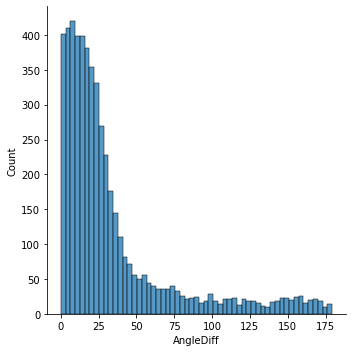

In [19]:
import seaborn as sns 
sns.displot(tests['AngleDiff']);

In [44]:
tests.isna().sum()

s                                         0
a                                         0
dis                                       0
o                                         0
dir                                       0
event                                     0
frameId                                   0
gameId                                    0
playId                                    0
season                                    0
team                                      0
position                                  0
displayName                               0
quarter                                   0
oppMean                                   0
oppX                                      0
oppY                                      0
oppMinDist                                0
oppMateDistRatio                          0
mateMinDist                               0
mateX                                     0
mateY                                     0
diffDir                         

In [45]:
tests.dropna(inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


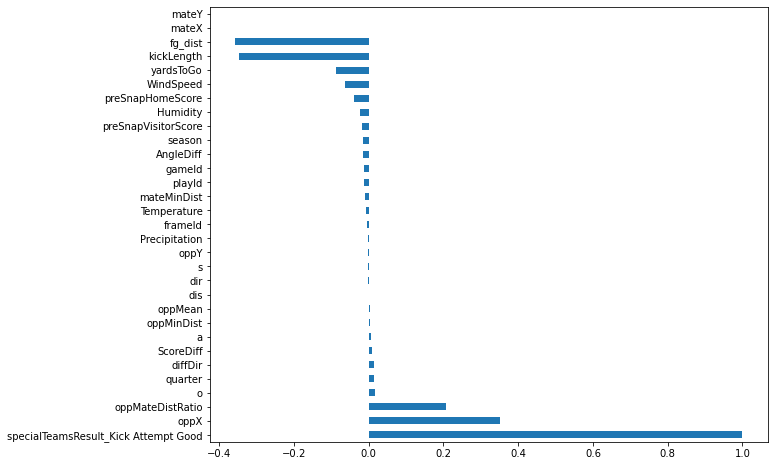

In [33]:
#Plot the correlation between the variables and target variable "specialTeamsResult_Kick Attempt Good"
plt.figure(figsize=(10,8))
tests.corr()['specialTeamsResult_Kick Attempt Good'].sort_values(ascending = False).plot(kind='barh');

The Pearson's correlation coefficient can be used to examine the linear relationship between the independent variables and dependent variable (field goal result). This is depicted using a correlation matrix and can be seen in the figure below. The correlation coefficient indicates the strength of the relationship in data and ranges from -1 to 1. Most of the features are uncorrelated, but some unsurpisingly are. For example, a player's distance traveled is strongly correlated with their speed. 

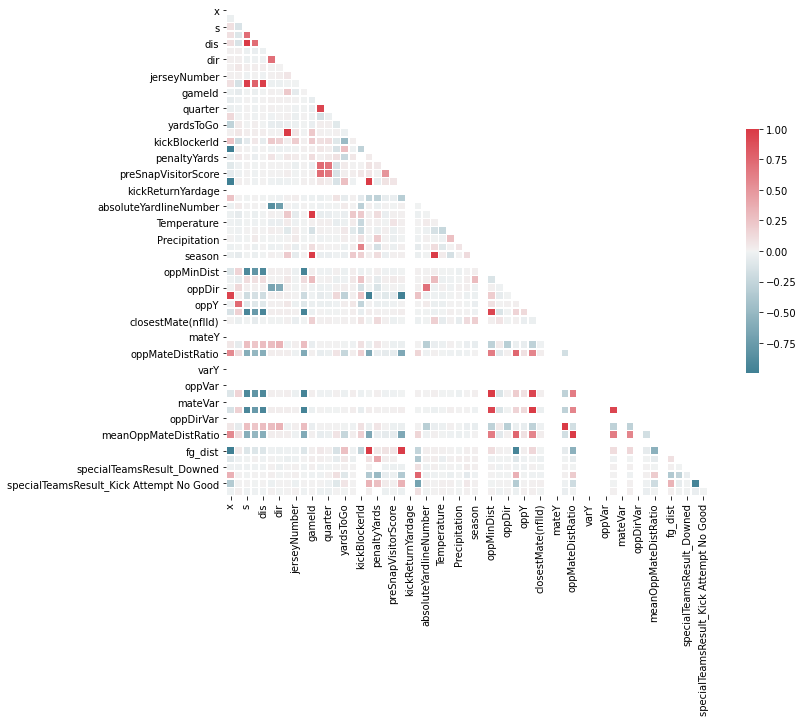

In [39]:
# Adapted from seaborn documentation: https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = fg.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

We will now split the data into X and y. Additionally, we will use 75% of the data to train the model and 25% to evaluate it. The data is umbalanced, with the majority of attempts being made. This isn't an issue as we will use evaluation metrics more suitable for this situation.

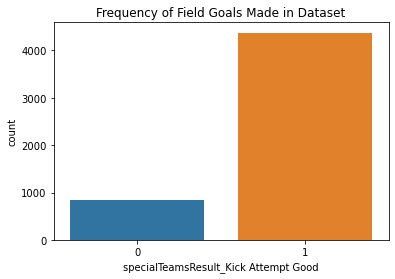

In [41]:
sns.countplot(x=tests['specialTeamsResult_Kick Attempt Good']);
plt.title("Frequency of Field Goals Made in Dataset");

In [36]:
# Split into X and y
# Drop unneeded columns
X = tests.drop([
       'displayName', 'frameId', 'gameId', 'playId', 'event', 'season', 'team', 'position',
        'quarter', 'playDescription', 'kickLength', 'oppX', 'oppY', 'mateX', 'mateY',
    'preSnapHomeScore', 'preSnapVisitorScore', 
       'specialTeamsResult_Kick Attempt Good'], axis=1)
features = X.columns
y = tests['specialTeamsResult_Kick Attempt Good']

In [67]:
#train test split: 75% train set and 25% test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=0)

# summarize split
print('Train data rows = %d, columns = %d' % (X_train.shape[0], X_train.shape[1]))
print('Test data rows = %d, columns = %d' % (X_test.shape[0], X_test.shape[1]))

Train data rows = 3483, columns = 18
Test data rows = 1161, columns = 18


### Model Features

Over 100 play features were considered to estimate performance. A subset of these were found to have the most utility to extract signals and quantify the difficulty of a play. These key features described below are calculated every tenth of a second. The NGS tracking data was the source of all of these features, except as noted.

- **`s`:** Kicker/Punter speed, yards/second
- **`a`:** Kicker/Punter acceleration, yards/second^2
- **`dis`:** Kicker/Punter distance traveled
- **`o`:** Kicker/Punter orientation, degrees
- **`dir`:** Angle of kicker motion (deg), 0 - 360 degrees
- **`AngleDiff`:** Angular difference between kicker/punter orientation and direction, degrees
- **`diffDir`:** Mean difference in direction of motion between the kicker/punter and the closest opponent player 
- **`oppMean`:** Mean distance from the nearest opposing player to kicker/punter
- **`mateMean`:**  Mean distance from the nearest teammate to kicker/punter
- **`oppMinDist`:** Distance of closest opposing player to kicker/punter
- **`mateMinDist`:** Distance of closest teammate to kicker/punter
- **`oppMateDistRatio`:** Mean distance ratio of the closest opponent player to closest teammate
- **`fg_dist`:** Distance of field goal
- **`Ez_dist`:** Distance to end zone
- **`ScoreDiff`:** Score difference of kicking team
- **`yardsToGo`:** Distance needed for first down
- **`Temperature`:** Temperature in Fahrenheit ([2](https://www.kaggle.com/tombliss/weather-data))
- **`Humidity`:** Humidity in percentage ([2](https://www.kaggle.com/tombliss/weather-data))
- **`Precipitation`:** Precipitation in inches ([2](https://www.kaggle.com/tombliss/weather-data))
- **`WindSpeed`:** Wind speed in miles per hour ([2](https://www.kaggle.com/tombliss/weather-data))

In order to find the best hyperparameters, I used [Optuna](https://github.com/optuna/optuna). Optuna is an automatic hyperparameter optimization framework. It is very effective and simple to use.

In [68]:
import optuna
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [42]:
# Code adapted from Optuna example: https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_cv_integration.py

def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "silent": 1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "verbosity": 0,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    # Add a callback for pruning.
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-logloss")
    history = xgb.cv(param, dtrain, num_boost_round=100, callbacks=[pruning_callback])

    mean_logloss = history["test-logloss-mean"].values[-1]
    return mean_logloss

if __name__ == "__main__":
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study = optuna.create_study(pruner=pruner, direction="minimize")
    study.optimize(objective, n_trials=15)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-01-13 11:11:48,888] A new study created in memory with name: no-name-be8b0e54-89d1-4adc-aca2-8a4076e00df6
[I 2022-01-13 11:11:49,120] Trial 0 finished with value: 0.379245 and parameters: {'booster': 'gblinear', 'lambda': 1.0793715984236553e-05, 'alpha': 0.0009002407267257922}. Best is trial 0 with value: 0.379245.
[I 2022-01-13 11:11:49,577] Trial 1 finished with value: 0.6930540000000001 and parameters: {'booster': 'gbtree', 'lambda': 2.647090621989264e-07, 'alpha': 1.936010711926938e-08, 'max_depth': 5, 'min_child_weight': 3, 'eta': 1.700422161952295e-06, 'gamma': 0.013850535369312559, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.379245.
[I 2022-01-13 11:11:49,726] Trial 2 finished with value: 0.369834 and parameters: {'booster': 'gblinear', 'lambda': 3.503179002617799e-06, 'alpha': 2.619589144727956e-06}. Best is trial 2 with value: 0.369834.
[I 2022-01-13 11:11:49,897] Trial 3 finished with value: 0.36992833333333336 and parameters: {'booster': 'gblinear', 'l

Number of finished trials: 15
Best trial:
  Value: 0.369834
  Params: 
    booster: gblinear
    lambda: 3.503179002617799e-06
    alpha: 2.619589144727956e-06


In [21]:
# train the XGBoost model
import xgboost
model = xgboost.XGBClassifier(booster='gbtree',
                             alpha=9.616351229014933e-08, max_depth=9, min_child_weight=7,
                             eta=0.02983113799807632, gamma=0.0016528998714932712, grow_policy='lossguide')
model.fit(X_train, y_train);
model

XGBClassifier(alpha=9.616351229014933e-08, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eta=0.02983113799807632, gamma=0.0016528998714932712, gpu_id=-1,
              grow_policy='lossguide', importance_type='gain',
              interaction_constraints='', learning_rate=0.0298311375,
              max_delta_step=0, max_depth=9, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=9.61635109e-08,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

## Model Evaluation

Classification models are optimized for log loss since we were primarily interested in the predicted probabilities. The field goal model has an AUC of 0.82, log loss of 0.33, and brier score loss of 0.105 on the evaluation set. The extra point model has an AUC of 0.63, log loss of 0.24, and brier score loss of 0.06 on the evaluation set.

In [70]:
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score
y_scores_xg = model.predict_proba(X_test)[:,1]
y_pred_xg = model.predict(X_test)

print("Train accuracy:",model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))
print("ROC AUC:", roc_auc_score(y_test, y_scores_xg))
print("Test Log Loss:", log_loss(y_test, y_scores_xg))
print("5 Fold CV Scores:", cross_val_score(model, X, y, cv=5, scoring = 'roc_auc'))

Train accuracy: 1.0
Test accuracy: 0.8604651162790697
ROC AUC: 0.8208317320569707
Test Log Loss: 0.3694403458099983
5 Fold CV Scores: [0.82338585 0.83699117 0.80762267 0.85998552 0.8097674 ]


In [71]:
from sklearn.metrics import brier_score_loss
brier_score_loss(y_test, y_scores_xg)

0.10509990696732173

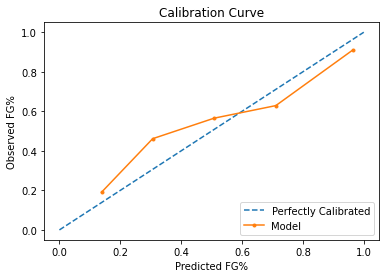

In [57]:
from sklearn.calibration import calibration_curve 
import matplotlib.pyplot as plt 

# Creating Calibration Curve 
x, y = calibration_curve(y_test, y_scores_xg, n_bins = 5, normalize = True) 
  
# Plot calibration curve 
  
# Plot perfectly calibrated 
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Perfectly Calibrated') 
  
# Plot model's calibration curve 
plt.plot(y, x, marker = '.', label = 'Model') 
  
leg = plt.legend(loc = 'lower right') 
plt.xlabel('Predicted FG%') 
plt.ylabel('Observed FG%') 
plt.title('Calibration Curve')
plt.show()

The area under the curve of a receiver operating charateristic (ROC AUC) is a common classification metric and is particularly well suited for imbalanced tasks (such as predicting whether an extra point will be made or missed). AUC compares the true positive rate and false positive rate of a classifier. A perfect model has an AUC of 1 while a random classifier has an AUC of 0.5. The field goal model has an AUC of 0.82 on data witheld from training.

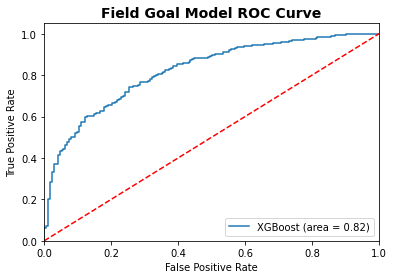

In [58]:
from sklearn.metrics import roc_auc_score
xg_roc_auc = roc_auc_score(y_test, model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGBoost (area = 0.82)' % xg_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Field Goal Model ROC Curve", fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.show()

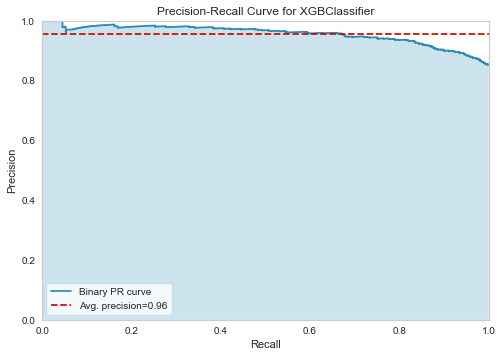

In [251]:
from yellowbrick.classifier import PrecisionRecallCurve
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show();

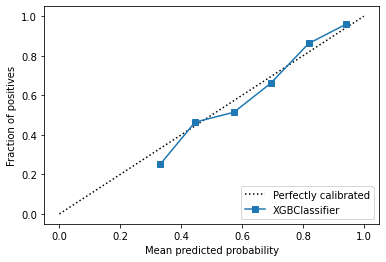

In [122]:
from sklearn.calibration import CalibrationDisplay
disp = CalibrationDisplay.from_estimator(model, X_test, y_test, n_bins=8)

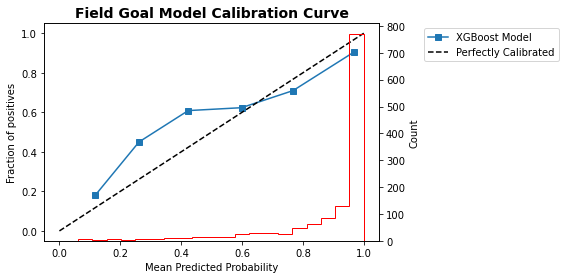

In [75]:
# Calibration curves
from sklearn.calibration import calibration_curve

prob = model.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_true=y_test, y_prob=prob, n_bins=6)

fig, ax1 = plt.subplots()
ax1.set_title("Field Goal Model Calibration Curve", fontsize=14, fontweight='bold')
ax1.plot(prob_pred, prob_true, marker='s', label='XGBoost Model')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='black')
ax1.legend(bbox_to_anchor=(1.12, 1), loc='upper left')
ax1.set_xlabel("Mean Predicted Probability")
ax1.set_ylabel("Fraction of positives")
ax2 = ax1.twinx()
ax2.hist(prob, bins=20, histtype='step', color='red') 
ax2.set_ylabel("Count")
plt.show()

## Interpretability

Model features are evaluated using SHAP (SHapley Additive exPlanations). SHAP values are a widely used approach to evaluate the output of a machine learning model. SHAP values identify the most important features, such as field goal distance. They also provide accurate local explanations (i.e how a prediction was made on a particular play).

In [36]:
import shap

In [37]:
# compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

 96%|=================== | 5003/5212 [00:19<00:00]       

The figure below provides teams with a ranking and evaluation of the most important features that contribute to a successful field goal. Accounting for field conditions provides better estimates of play difficulty. A close field goal attempt, low wind speed, high temperature, and low angle difference of the kicker (kicker moving and looking in the same direction) are all positive predictors of a successful field goal. Conversely, some negative indicators are adverse weather conditions, high kicker speed, and pressure from opposing players. 

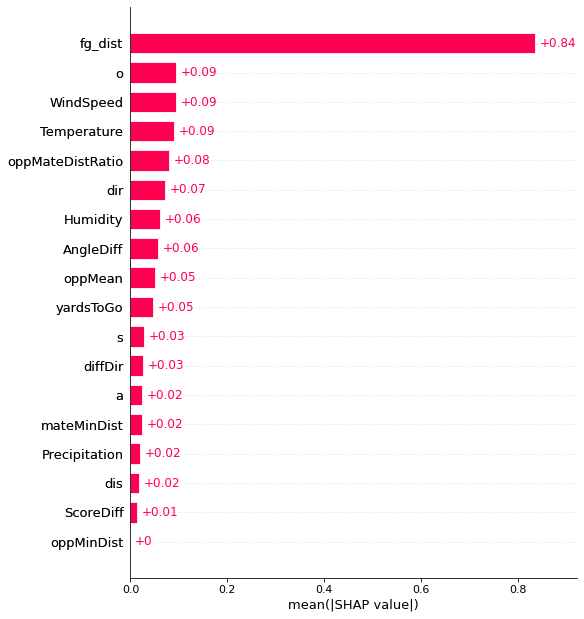

In [38]:
shap.plots.bar(shap_values, max_display=25)

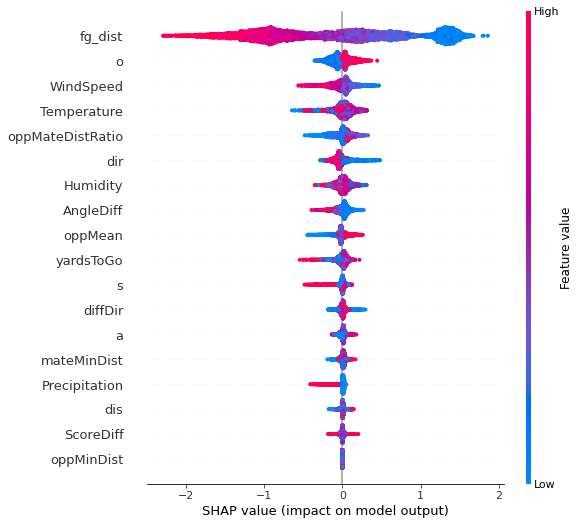

In [39]:
shap.plots.beeswarm(shap_values, max_display=25)

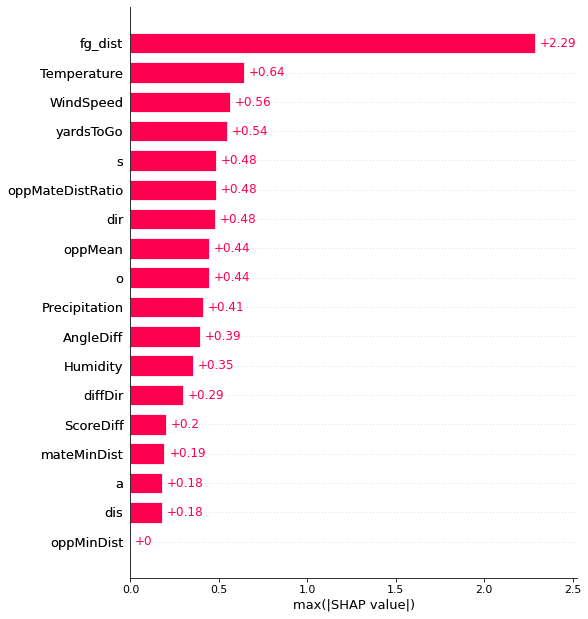

In [40]:
#Sort by maximum value
shap.plots.bar(shap_values.abs.max(0), max_display=23)

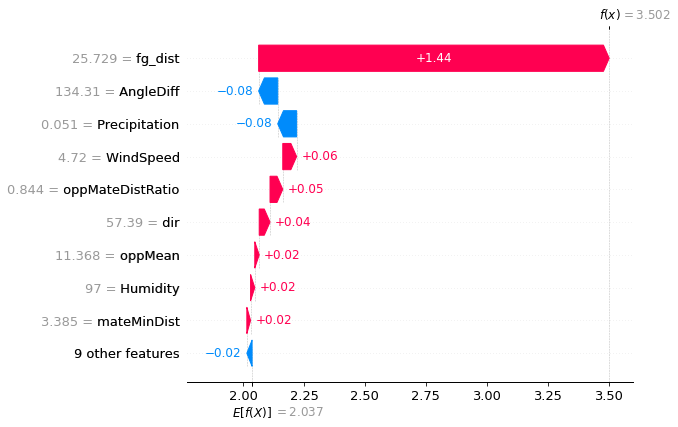

In [41]:
shap.plots.waterfall(shap_values[10])

In [42]:
# Display SHAP Interaction Values
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X)

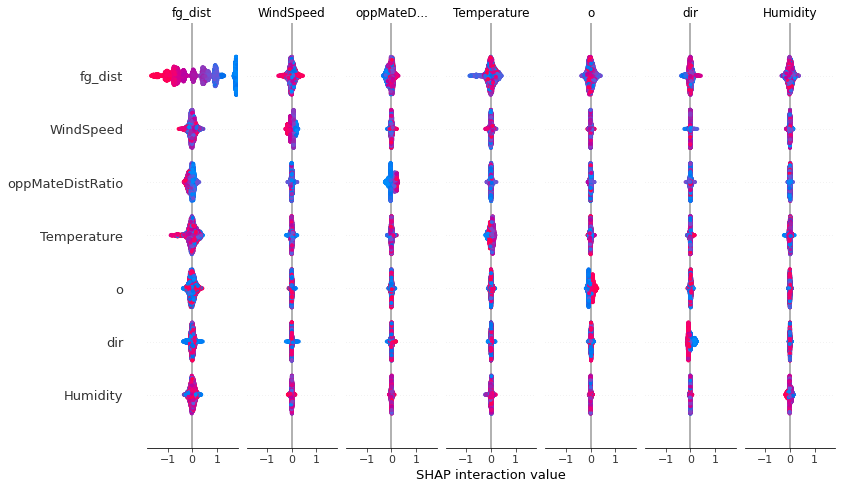

In [43]:
shap.summary_plot(shap_interaction_values, X)

In [44]:
import matplotlib.pylab as plt
import numpy as np

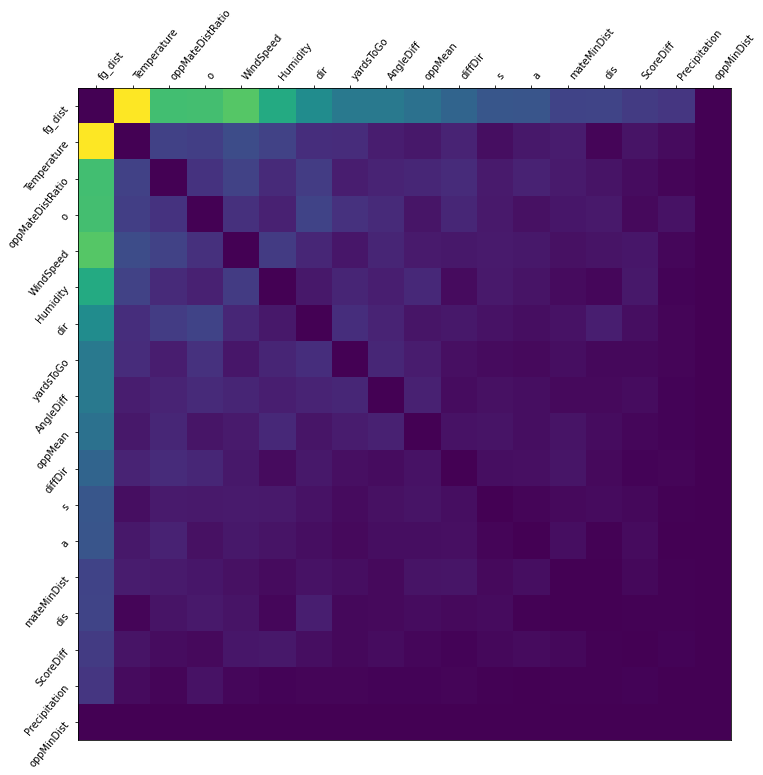

In [45]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
plt.figure(figsize=(12,12))
plt.imshow(tmp2)
plt.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
plt.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
plt.gca().xaxis.tick_top()
plt.show()

Another interpretability method is permutation importance. Permutation importance measures how much a performance score decreases when a feature isn't available. Instead of removing the feature entirely, it is replaced with random noise (permuted) and measures how the performance changes when the feature is replaced. This is calculated on the test set after the model has been fit. An issue with this method is that it may understate the importance of certain features if there is multicollinearity. SHAP is the preferred method when dealing with multicollinearity and identifying interactions in data (such as NFL player tracking data). 

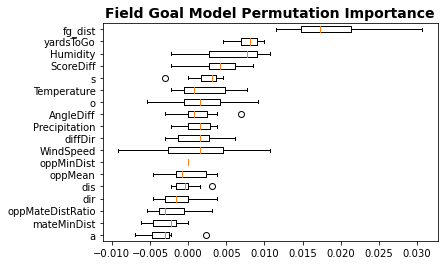

In [76]:
# from Sklearn documentation: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py
from sklearn.inspection import permutation_importance
result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Field Goal Model Permutation Importance", fontsize=14, fontweight='bold')
plt.show()

In [47]:
#Make predictions on entire dataset
y_pred = model.predict_proba(X)[:,1]
y_pred

array([0.90560764, 0.9032492 , 0.5790805 , ..., 0.43621925, 0.652718  ,
       0.9685166 ], dtype=float32)

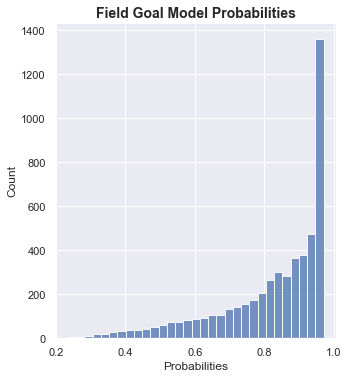

In [87]:
import seaborn as sns
ax = sns.displot(y_pred);
ax = plt.xlabel('Probabilities')
ax = plt.ylabel('Count')
ax = plt.title("Field Goal Model Probabilities", fontsize=14, fontweight='bold')

In [48]:
tests['FGProb'] = y_pred
tests


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,s,a,dis,o,dir,event,frameId,gameId,playId,season,team,position,displayName,quarter,oppMean,oppX,oppY,oppMinDist,oppMateDistRatio,mateMinDist,mateX,mateY,diffDir,playDescription,kickLength,yardsToGo,fg_dist,preSnapHomeScore,preSnapVisitorScore,Temperature,Humidity,Precipitation,WindSpeed,specialTeamsResult_Kick Attempt Good,ScoreDiff,AngleDiff,FGProb
0,0.29,0.17,0.04,130.24,118.34,ball_snap,11,2018123000,373,2018,home,K,Justin Tucker,1,11.233472,90.62,31.750000,11.233472,0.417043,4.200202,117.55,32.32,151.75,"(9:31) J.Tucker 38 yard field goal is GOOD, Ce...",38.0,8,40.891037,0,0,42.98,70.0,0.0,0.00,1,0.0,11.90,0.905608
1,0.18,0.19,0.04,310.20,314.85,ball_snap,11,2018123000,1538,2018,home,K,Justin Tucker,2,11.471412,93.28,26.153333,11.471412,0.458102,4.131053,117.55,32.32,232.55,(6:15) (Field Goal formation) J.Tucker 35 yard...,35.0,10,38.191665,17,7,42.98,70.0,0.0,0.00,1,10.0,4.65,0.903249
2,0.00,0.00,0.00,132.80,122.39,ball_snap,11,2018123000,2314,2018,away,K,Greg Joseph,2,10.770241,82.24,26.680000,10.770241,0.301201,3.729410,117.55,32.32,137.07,(:04) (Field Goal formation) G.Joseph 46 yard ...,46.0,5,48.510991,20,7,42.98,70.0,0.0,0.00,0,-13.0,10.41,0.579081
3,0.13,0.10,0.02,128.51,134.32,ball_snap,11,2018123000,2860,2018,home,K,Justin Tucker,3,11.084728,84.60,33.590000,11.084728,0.336161,4.337568,117.55,32.32,131.19,(7:08) (Field Goal formation) J.Tucker 44 yard...,44.0,14,46.915264,20,14,42.98,70.0,0.0,0.00,1,6.0,5.81,0.838688
4,0.00,0.00,0.00,142.44,110.59,ball_snap,11,2018123000,3378,2018,away,K,Greg Joseph,4,10.642016,93.38,33.930000,10.642016,0.439325,3.632754,117.55,32.32,125.04,(13:48) (Field Goal formation) G.Joseph 35 yar...,35.0,8,37.641016,23,14,42.98,70.0,0.0,0.00,1,-9.0,31.85,0.852922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5207,2.76,2.86,0.28,113.92,106.03,field_goal_attempt,26,2020091400,2941,2020,away,K,Chris Boswell,4,4.843139,87.93,33.560000,4.843139,0.163366,1.522104,117.55,32.32,137.24,"(14:24) C.Boswell 36 yard field goal is GOOD, ...",36.0,10,36.540052,10,16,69.08,45.0,0.0,11.18,1,6.0,7.89,0.920370
5208,3.56,1.45,0.34,322.35,289.56,field_goal_attempt,26,2020091401,612,2020,away,K,Stephen Gostkowski,1,7.498513,79.22,28.643333,7.498513,0.194737,1.520691,117.55,32.32,211.12,(5:27) S.Gostkowski 47 yard field goal is No G...,47.0,7,48.188859,0,0,71.06,27.0,0.0,5.59,0,0.0,32.79,0.535740
5209,3.67,0.72,0.36,122.38,108.95,field_goal_attempt,26,2020091401,2010,2020,away,K,Stephen Gostkowski,2,5.171305,79.92,33.110000,5.171305,0.137395,1.328834,117.55,32.32,118.43,(:12) S.Gostkowski 44 yard field goal is BLOCK...,NaN,12,44.993711,7,7,71.06,27.0,0.0,5.59,0,0.0,13.43,0.436219
5210,3.45,1.16,0.34,321.04,289.00,field_goal_attempt,25,2020091401,2626,2020,away,K,Stephen Gostkowski,3,7.340191,82.84,24.873333,7.340191,0.206767,1.483543,117.55,32.32,164.64,(7:32) S.Gostkowski 42 yard field goal is No G...,42.0,10,42.995057,7,7,71.06,27.0,0.0,5.59,0,0.0,32.04,0.652718


In [21]:
# Export to a csv file
#tests.to_csv('fullpred.csv', index=False)